In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist


#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns

#misc
import time
np.set_printoptions(suppress=True)

## Visualization

### Heatmap Calculation

In [20]:
df = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run01/Run01_expected.h5')

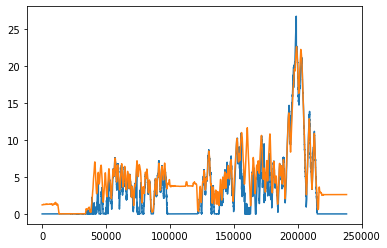

In [24]:
plt.plot(df.distance_along_streakline)
plt.plot(df.distance_from_source)

In [15]:
query = 'odor>=2'
df_occurence = df.query(query)

In [17]:
x = np.linspace(0,25,20)
y = np.linspace(0,25,20)
H1, x, y = np.histogram2d(df_occurence.distance_from_source, df_occurence.nearest_from_streakline, bins=(x, y), 
                          weights = df_occurence.odor)
N_Encounter = H1.T 
H2, x, y = np.histogram2d(df.distance_from_source, df.nearest_from_streakline, bins=(x, y), 
                          weights = df.odor)
Total = H2.T 

# Encounters = np.array(H1)/np.array(H2)
# Encounters[Encounters == np.inf] = 0

## removing areas less than 4000 deno

for i in range (len(Total)):
    for j in range(len(Total[i])):
        if Total[i][j]<800:
            Total[i][j] =0
            N_Encounter[i][j]=0

Encounters = np.array(N_Encounter)/np.array(Total)
Encounters[Encounters == np.inf] = 0

<ipython-input-17-1b8eb04e14a5>:21: RuntimeWarning: invalid value encountered in true_divide
  Encounters = np.array(N_Encounter)/np.array(Total)


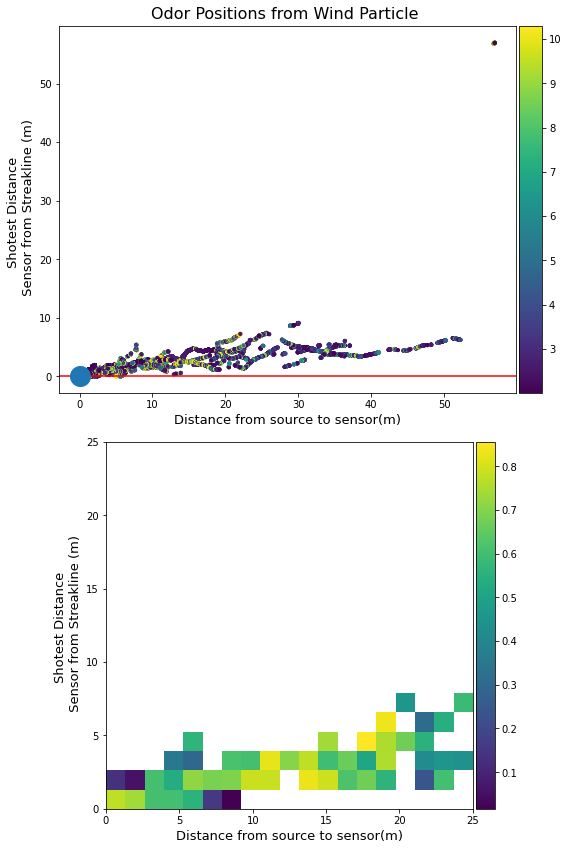

In [19]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(8,12) , gridspec_kw={'height_ratios': [4,4]})

#plot wind vs odor from source and each other
f.suptitle('Odor Positions from Wind Particle', fontsize = 16)
# ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
var = ax1.scatter(df_occurence.distance_from_source, df_occurence.nearest_from_streakline, cmap = 'viridis', 
                  c = df_occurence.odor,  s = 10)
# ax1.set_xlabel('Distance along Streakline(m)' , fontsize = 13)
ax1.set_xlabel('Distance from source to sensor(m)' , fontsize = 13)
ax1.set_ylabel('Shotest Distance \n Sensor from Streakline (m)' , fontsize = 13)



divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'vertical')

# x = np.linspace(0,25,11)
# y = np.linspace(0,10,25)
# ax2.set_xlabel('Distance along Streakline(m)', fontsize = 13)
ax2.set_xlabel('Distance from source to sensor(m)' , fontsize = 13)
ax2.set_ylabel('Shotest Distance \n Sensor from Streakline (m)', fontsize = 13)
var2 = ax2.imshow(Encounters, interpolation='nearest', origin='lower',cmap = 'viridis', extent=[x[0], x[-1], y[0], y[-1]])
start, end = ax2.get_xlim()

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var2, cax=cax, orientation = 'vertical')

f.tight_layout()
f.savefig('../../test01.jpeg')

### Time Series Plot

In [ ]:
f, (ax1,ax2) = plt.subplots(2, 1,figsize=(15,6))
# ax1.set_prop_cycle('color',[plt.cm.OrRd(i) for i in df.odor])

# ax1.set_facecolor('black')
ax1.plot(df.sync_time, df.odor, color='Purple')
ax1.set_ylabel('Odor \n Concentration', fontsize=15)
ax1.title.set_text('Encountered Particle')
ax2.plot(df.sync_time,df.odor_expected, color='C1')
ax2.set_xlabel('Time (secs)', fontsize=15)
ax2.set_ylabel('Odor \n Presence', fontsize=15)
ax2.title.set_text('Calculated Particle')

f.suptitle('Radius**0.5*.01', fontsize =20)
f.tight_layout()
# f.savefig(dir_save+'Run0'+str(run)+'_encounteredVsExpected.jpeg')

### Summary Plot

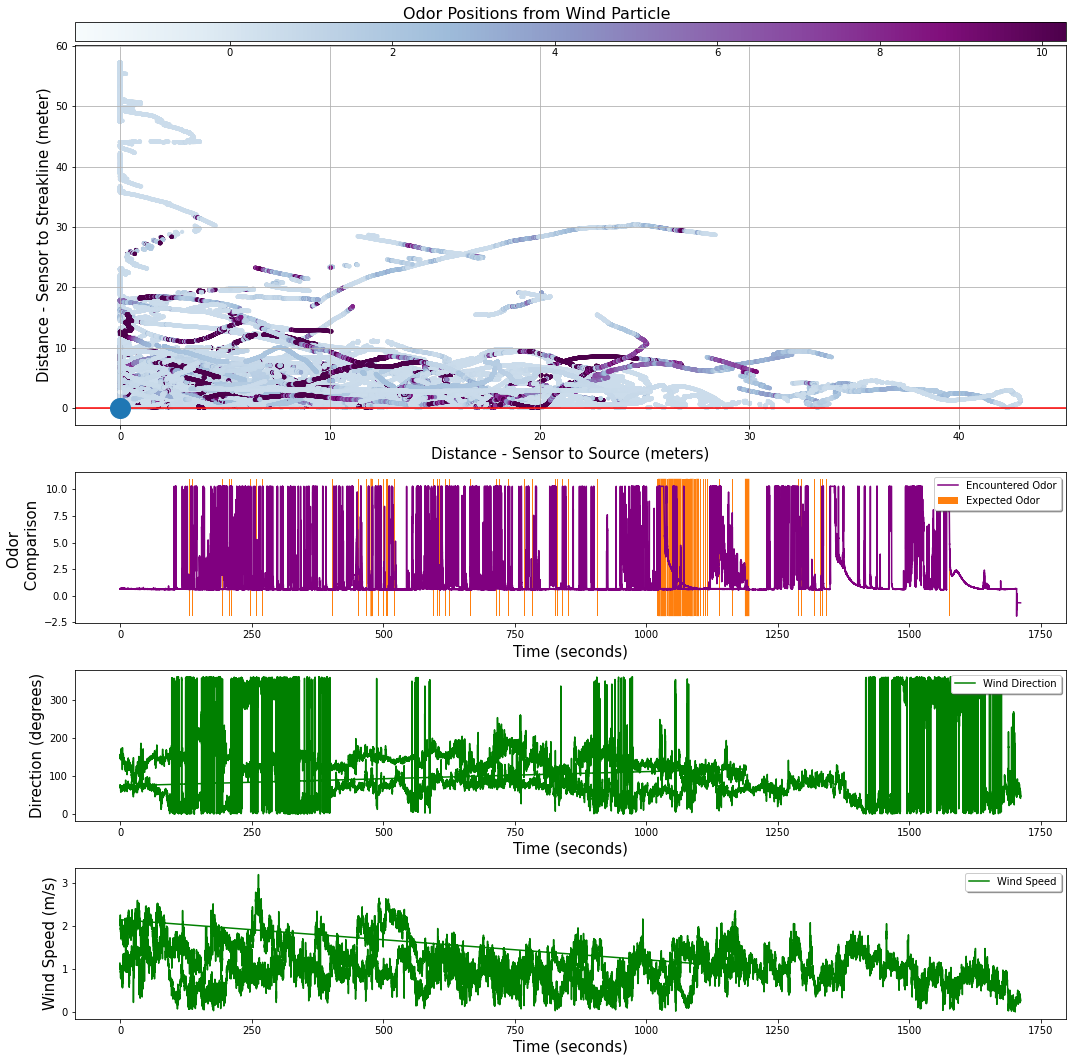

In [9]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize =(15,15) , gridspec_kw={'height_ratios': [8,3,3,3]})

#plot wind vs odor from source and each other
f.suptitle('Odor Positions from Wind Particle', fontsize = 16)
# ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
# area = df.radius**2*0.4*m.pi #area
# ax1.scatter(area[0:30]**2,df.mock[0:30])
# ax1.scatter(df.sync_time[::300], df.mock[::300],  facecolors='none', edgecolors='b', s = area[::300])
var = ax1.scatter(df.distance_along_streakline, df.nearest_particle, cmap = 'BuPu', c = df.odor,  s = 10)
ax1.set_xlabel('Distance - Sensor to Source (meters)' , fontsize = 15)
ax1.set_ylabel('Distance - Sensor to Streakline (meter)' , fontsize = 15)
# ax1.xaxis.set_ticks(np.linspace(0, 30, 31).astype(int))
# ax1.yaxis.set_ticks(np.linspace(0, 35, 10).astype(int))
ax1.grid()

divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'horizontal')

#plot concentration
ax2.plot(df.sync_time,df.odor,color='Purple' , label="Encountered Odor")
ax2.fill_between(df.sync_time, df.odor.min(), 11, where=df.odor_expected>0 ,facecolor='C1', alpha=1, label="Expected Odor")
# ax2.plot(df.sync_time, df.odor_expected, label="Expected Odor")
ax2.set_xlabel('Time (seconds)' , fontsize = 15)
ax2.set_ylabel('Odor \n Comparison' , fontsize = 15)
# ax2.set_facecolor('black')

lgd=ax2.legend(loc='upper right',fancybox=True, shadow=True)

## plot direction
ax3.plot(df.sync_time,df.D, color = 'green', label="Wind Direction")
# ax3.plot(df.sync_time,sensor_direction, color = 'purple', label="Sensor Direction")
ax3.set_xlabel('Time (seconds)' , fontsize = 15)
ax3.set_ylabel('Direction (degrees)' , fontsize = 15)
# ax3.axhline(150, color = 'red')
lgd=ax3.legend(loc='upper right',fancybox=True, shadow=True)



## plot speed
ax4.plot(df.sync_time,df.S2, color = 'green', label="Wind Speed")
ax4.set_xlabel('Time (seconds)' , fontsize = 15)
ax4.set_ylabel('Wind Speed (m/s)' , fontsize = 15)
lgd=ax4.legend(loc='upper right',fancybox=True, shadow=True)
# ax4.axhline(1.0, color = 'red')

f.tight_layout()

# f.savefig(dir_save+'Run0'+str(run)+'_plot_summary.jpeg')